In [3]:
from __future__ import division, print_function
import sys
if '..' not in sys.path:
    sys.path.insert(0, '..')
from sigr.evaluation import CrossValEvaluation, Exp
from sigr import Context
from sigr.utils import Bunch
from sigr.data import Dataset, Preprocess
import numpy as np
import mxnet as mx
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('paper', rc={'font.family': 'Arial', 'font.size': 7})
sns.set_style('whitegrid')
import pandas as pd


class Report(Bunch):
    
    def __call__(self):
        crossval = getattr(self, 'crossval', 'one-fold-intra-subject')
        evaluation = CrossValEvaluation(crossval_type=crossval, batch_size=1000)
        exp = Exp(dataset=Dataset.from_name(self.dataset),
                  dataset_args=getattr(self, 'dataset_args', None),
                  Mod=dict(num_gesture=self.num_gesture,
                           context=[mx.gpu(0)],
                           symbol_kargs=dict(dropout=0,
                                             num_semg_row=self.num_semg_row, num_semg_col=self.num_semg_col, 
                                             num_filter=64),
                           params='.cache/sigr-{}-{}-%d-v{}/model-{:04d}.params'.format(
                               getattr(self, 'dataset_in_cache', self.dataset).replace('/', '-'),
                               crossval,
                               self.version,
                               getattr(self, 'num_epoch', 28)),
                           **getattr(self, 'mod', {})))
        with Context(parallel=True, level='DEBUG'):
            acc = evaluation.accuracies(
                [Exp(vote=-1, **exp)],
                folds=list(range(self.num_fold)))
            trialacc = acc.mean()
        with Context(parallel=True, level='DEBUG'):
            acc = evaluation.vote_accuracy_curves(
                [exp],
                folds=list(range(self.num_fold)),
                windows=self.windows,
                balance=getattr(self, 'balance', False))
        std = acc.std(axis=(0, 1))
        acc = acc.mean(axis=(0, 1))

        df = pd.DataFrame([100 * acc[0],
                           100 * std[0],
                           100 * acc[self.windows == self.w150][0],
                           100 * trialacc,
                           self.frame_to_ms(self.windows[np.where(acc > self.threshold)[0][0]]
                                            if acc[-1] > self.threshold else 0)],
                          index=['No voting', 
                                 'Std',
                                 '150ms voting', 
                                 'Trial voting', 
                                 '%f%% window' % (100 * self.threshold)])
        print(df.round(1).to_string(header=False))
        
        plt.plot(self.windows, 100 * acc, label=getattr(self, 'label', None))
        plt.xlabel('Voting window (ms)')
        plt.ylabel('Accuracy (%)', labelpad=0)
        plt.xlim(self.windows[0], self.windows[-1])
        plt.ylim(self.ymin, 100)
        if hasattr(self, 'xticks'):
            if hasattr(self, 'xlabels'):
                plt.xticks(self.xticks, self.xlabels)
            else:
                plt.xticks(self.xticks, [str(self.frame_to_ms(x)) for x in self.xticks])
        #plt.gcf().set_size_inches(6, 4)
        #plt.show()
        
    def frame_to_ms(self, frame):
        if frame < 1:
            return frame
        ms = np.round(frame / Dataset.from_name(self.dataset).framerate * 1000)
        return int(np.round(ms)) if np.abs(np.round(ms) - ms) < 1e-4 else ms
        
        
class NinaPro(Report):
    
    def __init__(self, **kargs):
        options = dict(
            threshold=0.99
        )
        options.update(kargs)
        super(NinaPro, self).__init__(**options)
        self.num_fold = 27
        self.num_semg_row = 1
        self.num_semg_col = 10
        self.windows = np.arange(1, 101)
        #self.threshold = 0.99
        self.w150 = 15
        self.xticks = [1, 20, 40, 60, 80, 100]
        #self.xlabels = ['1', '200', '400', '600', '800', '1000']
        self.ymin = 65
        self.balance = True
        
        
class CapgMyo(Report):
    
    def __init__(self, **kargs):
        super(CapgMyo, self).__init__(**kargs)
        self.num_semg_row = 16
        self.num_semg_col = 8
        self.windows = np.arange(1, 1001)
        self.threshold = 0.99
        self.w150 = 150
        self.xticks = [1, 200, 400, 600, 800, 1000]
        self.ymin = 80
        
        
class CSL(Report):
    
    def __init__(self, **kargs):
        super(CSL, self).__init__(**kargs)
        self.num_semg_row = 24
        self.num_semg_col = 7
        self.windows = np.arange(1, 2049)
        self.threshold = 0.904
        self.w150 = int(np.round(0.15 * 2048))
        self.xticks = [1] + [256 * x for x in range(1, 9)]
        self.ymin = 50
        self.num_gesture = 27
        self.dataset_args = dict(preprocess=Preprocess.parse('(csl-bandpass,csl-cut,median)'))
        self.num_fold = 250
        self.mod = dict(adabn=True, num_adabn_epoch=10)
        self.crossval = 'intra-session'
        #self.num_epoch = 14
        self.balance = True
        
        
def report(cls, *args, **kargs):
    #plt.figure(figsize=(6, 6./4*3))
    if not args:
        cls(**kargs)()
    else:
        assert not kargs
        for i, arg in enumerate(args):
            if i:
                print('---')
            cls(**arg)()
        plt.legend()
        
        
def savefig(prefix):
    for ext in ['.jpg', '.eps', '.pdf']:
        plt.savefig(prefix + ext, dpi=300, bbox_inches='tight', pad_inches=0.05)

No voting          89.3
Std                 4.9
150ms voting       99.5
Trial voting       99.7
99.000000% window  40.0
---
No voting           55.8
Std                  5.9
150ms voting        89.3
Trial voting        96.8
90.400000% window  171.0
---
No voting          78.9
Std                 5.3
150ms voting       83.0
Trial voting       97.7
99.000000% window   0.0
---
No voting           65.1
Std                  5.3
150ms voting        71.0
Trial voting        96.7
75.320000% window  280.0


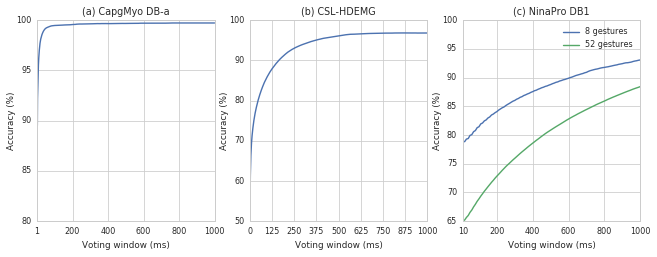

In [14]:
plt.subplot(131)
report(CapgMyo, dataset='dba', version='958.3.2', num_gesture=8, num_fold=18)
plt.title('(a) CapgMyo DB-a')
print('---')
plt.subplot(132)
report(CSL, dataset='csl', version='958.5.1.1')
plt.title('(b) CSL-HDEMG')
print('---')
plt.subplot(133)
report(NinaPro,
       dict(dataset='ninapro-db1/g8', version='958.22.1', num_gesture=8, label='8 gestures'),
       dict(dataset='ninapro-db1', version='958.20.1', num_gesture=52, label='52 gestures', threshold=0.7532))
plt.title('(c) NinaPro DB1')
plt.gcf().set_size_inches(1.5 * 7.20472, 1.5 * 7.20472 / 3)
savefig('../.cache/figures/srep-curve')

No voting           65.1
Std                  5.3
150ms voting        71.0
Trial voting        96.7
75.320000% window  280.0


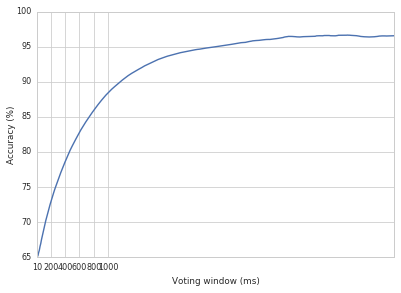

In [15]:
nina = NinaPro(dataset='ninapro-db1', version='958.20.1',
               num_gesture=52, label='52 gestures', threshold=0.7532)
nina.windows = np.arange(1, 501)
nina()

No voting           65.1
Std                  5.3
150ms voting        72.8
Trial voting        96.7
75.320000% window  280.0


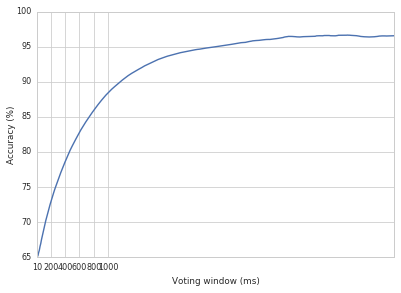

In [3]:
nina = NinaPro(dataset='ninapro-db1', version='958.20.1',
               num_gesture=52, label='52 gestures', threshold=0.7532)
nina.w150 = 20
nina.windows = np.arange(1, 501)
nina()

No voting          76.1
Std                 5.9
150ms voting       77.3
Trial voting       95.1
75.320000% window  10.0


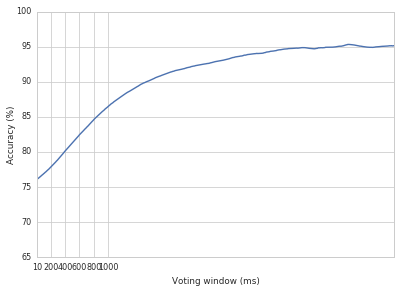

In [4]:
nina = NinaPro(dataset='ninapro-db1', version='958.20.4',
               num_gesture=52, label='52 gestures', threshold=0.7532)
nina.windows = np.arange(1, 501)
nina.dataset_args = dict(preprocess=Preprocess.parse('ninapro-lowpass'))
nina()

No voting          76.1
Std                 5.9
150ms voting       77.8
Trial voting       95.1
75.320000% window  10.0


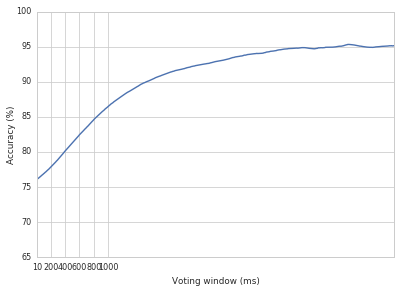

In [5]:
nina = NinaPro(dataset='ninapro-db1', version='958.20.4',
               num_gesture=52, label='52 gestures', threshold=0.7532)
nina.w150 = 20
nina.windows = np.arange(1, 501)
nina.dataset_args = dict(preprocess=Preprocess.parse('ninapro-lowpass'))
nina()

No voting          76.1
Std                 5.8
150ms voting       77.3
Trial voting       95.4
75.320000% window  10.0


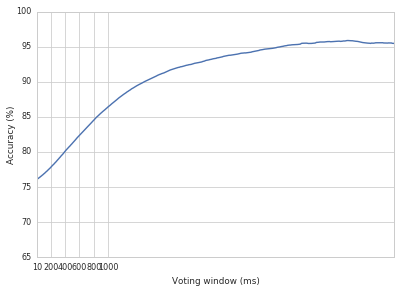

In [5]:
# matlab
nina = NinaPro(dataset='ninapro-db1-matlab-lowpass', version='958.20.10',
               num_gesture=52, label='52 gestures', threshold=0.7532)
nina.windows = np.arange(1, 501)
nina.dataset_in_cache = 'ninapro-db1'
nina()

No voting          76.1
Std                 5.8
150ms voting       77.8
Trial voting       95.4
75.320000% window  10.0


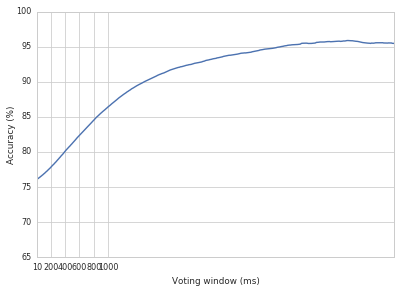

In [6]:
# matlab
nina = NinaPro(dataset='ninapro-db1-matlab-lowpass', version='958.20.10',
               num_gesture=52, label='52 gestures', threshold=0.7532)
nina.w150 = 20
nina.windows = np.arange(1, 501)
nina.dataset_in_cache = 'ninapro-db1'
nina()

No voting          75.9
Std                 5.7
150ms voting       77.2
Trial voting       95.0
75.320000% window  10.0


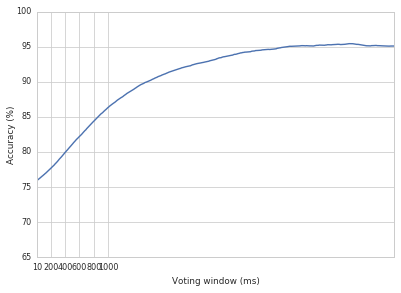

In [3]:
nina = NinaPro(dataset='ninapro-db1/g53', version='958.20.8',
               num_gesture=53, label='53 gestures', threshold=0.7532)
nina.windows = np.arange(1, 501)
nina.dataset_args = dict(preprocess=Preprocess.parse('ninapro-lowpass'))
nina()

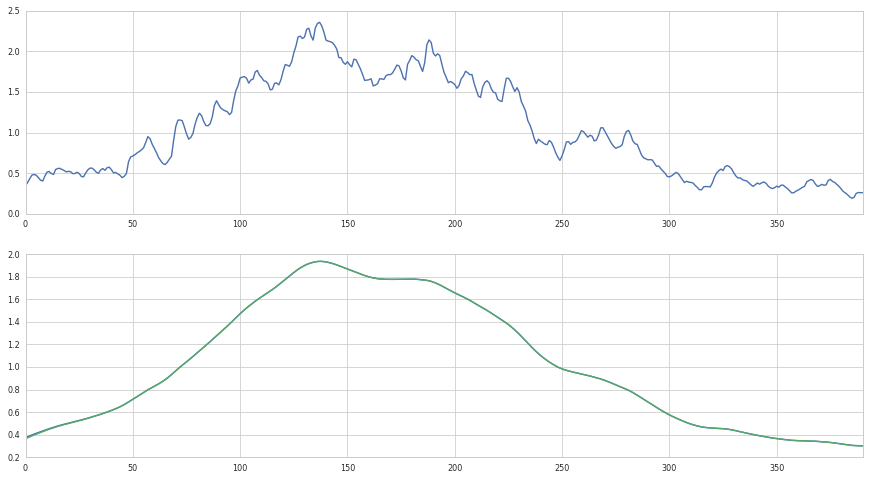

In [32]:
from sigr.utils import butter_lowpass_filter as lowpass
from scipy.ndimage.filters import median_filter
from sigr.data import Combo
import scipy.io as sio


db = Dataset.from_name('ninapro-db1')

get_trial = db.get_trial_func(db.gestures, db.trials)
with Context(parallel=True):
    trial = get_trial(db.root, Combo(subject=1, gesture=13, trial=0))
    data = trial.data[:, 0]
    plt.subplot(211)
    plt.plot(np.arange(len(data)), data)
    plt.xlim(0, len(data) - 1)
    
sio.savemat('../data.mat', dict(data=data))
        
get_trial = db.get_trial_func(db.gestures, db.trials, preprocess=Preprocess.parse('ninapro-lowpass'))
with Context(parallel=True):
    trial = get_trial(db.root, Combo(subject=1, gesture=13, trial=0))
    data = trial.data[:, 0]
    plt.subplot(212)
    plt.plot(np.arange(len(data)), data)
    plt.xlim(0, len(data) - 1)
    
y = sio.loadmat('../y.mat')['y']
y = y.ravel()
plt.plot(np.arange(len(y)), y)

plt.gcf().set_size_inches(15, 8)

In [31]:
np.max(np.abs(y - data))

0.011136081861754465